In [1]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import pandas as pd
from openpyxl import Workbook
import os
import ipdb
from scipy.interpolate import griddata
from sklearn.neighbors import KNeighborsRegressor
import time
import matplotlib.pyplot as plt
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output, display_html, HTML
import logging
from ipywidgets import Dropdown
# Ignore FutureWarnings
from tabulate import tabulate
import pymannkendall as mk
import scipy.stats as stats
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Script for clipping data

In [ ]:
def get_clean_state_name(shapefile_path):
    state = os.path.basename(shapefile_path)  # Get the base file name
    state = state.split('.')[0]  # Remove the file extension
    if state.endswith("_buffer"):
        state = state[:-7]  # Remove "_buffer" if present
    return state
def clip_data_by_bbox(AphoditeDataAdress, shapefilePath, ClippedFolderPath):
    # Read the shapefile
    # print(shapefilePath)
    gdf = gpd.read_file(shapefilePath)
    # ipdb.set_trace()
    # Get the geometry
    geometry = gdf['geometry']
    # Get the bounding box
    bbox = geometry.bounds
    # Get the coordinates
    xmin = bbox['minx'][0]
    xmax = bbox['maxx'][0]
    ymin = bbox['miny'][0]
    ymax = bbox['maxy'][0]

    #Masking
    # Open the NetCDF dataset using xarray
    ds = xr.open_dataset(AphoditeDataAdress)
    # Define the latitude and longitude variable names to check
    possible_lat_names = ['lat', 'latitude', 'Latitude', 'LAT', 'LATITUDE', 'Lat']
    possible_lon_names = ['lon', 'longitude', 'Longitude', 'LON', 'LONGITUDE', 'Lon']

    # Initialize variables to None
    lat_var = None
    lon_var = None

    # Try to find the latitude and longitude variables
    for lat_name in possible_lat_names:
        if lat_name in ds.variables:
            lat_var = ds[lat_name]
            break

    for lon_name in possible_lon_names:
        if lon_name in ds.variables:
            lon_var = ds[lon_name]
            break

    # Apply the mask to latitude and longitude using xarray indexing
    mask_lat = (lat_var >= ymin) & (lat_var <= ymax)
    mask_lon = (lon_var >= xmin) & (lon_var <= xmax)
    # ipdb.set_trace()
    if not mask_lat.any() or not mask_lon.any():
        return None 
    data = ds.where(mask_lat & mask_lon, drop=True)
    # dataset = regionmask.Regions(name='State_Name', numbers=[0], names=gdf.State_Name[[0]], abbrevs=gdf.State[[0]], outlines=gdf.geometry[[0]])
    # Provide the correct file path

    # Finding name of state to save with
    stateName = get_clean_state_name(shapefilePath)
    Year = AphoditeDataAdress.split('.')[-2]
    #APHRO_MA_025deg_V1101.2006.nc --> extract 2006

    # Construct the filename with stateName_Year.nc
    ClippedDataFile = f"{stateName}_{Year}.csv"
    # Construct full path for saving the CSV file
    csv_file_path  = os.path.join(ClippedFolderPath, ClippedDataFile)
    data = data.to_dataframe().reset_index()
    selected_Columns = ['time','lat','lon','tave']
    data = data[selected_Columns]
    # Remove leading and trailing spaces (if any) and rename columns
    data.columns = data.columns.str.strip() 
    data = data.rename(columns={'tave':'Temp', 'time' : 'Date'})
    data.to_csv(csv_file_path, index=False)
    # Save the .nc file for each indiividual state, for all years individually

def do_Clipping_Statewise(shapefilePath, AphoditeDataAdress, ClippedFolderPath,state):
    for dataset in os.listdir(AphoditeDataAdress):
        datasetPath = os.path.join(AphoditeDataAdress,dataset)
        clip_data_by_bbox(datasetPath, shapefilePath, ClippedFolderPath)


shapeFileAddress =['./Buffer_Boundary/J&K/J&K.shp',
                  './Buffer_Boundary/AP/AP_buffer.shp',
                  './Buffer_Boundary/HP/HP_buffer.shp',
                  './Buffer_Boundary/SK/SK_buffer.shp',
                  './Buffer_Boundary/UK/UK_buffer.shp']

# shapeFileAddress1 = ['./Buffer_Boundary/Jammu&Kashmir/J&K.shp']
AphoditeDataAdress = "./TempData"
ClippedFolderPath = "./TemperatureAnalysis/ClippedData"

if not os.path.exists(ClippedFolderPath):
    os.makedirs(ClippedFolderPath)


for file in (shapeFileAddress):
    shapefilePath = file

    state = get_clean_state_name(shapefilePath)
    statefolder = ClippedFolderPath + '/' + state
    if not os.path.exists(statefolder):#make state folder name if not exists
        os.makedirs(statefolder)
    print(f'---Clipping started for --{state}-------------------------------')
    do_Clipping_Statewise(shapefilePath, AphoditeDataAdress, statefolder, state)
    print(f'---Clipping completed for --{state}-------------------------------')

    

Time = 5 min

In [ ]:
file = './APHRO_MA_TAVE_025deg_V1808.1961.nc'
ds = xr.open_dataset(file)
print(ds)

# 2. Monthly mean Temperature
####  12 months separate files are made for each state from year 1961-2015

In [ ]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import pandas as pd
from openpyxl import Workbook
import os
import ipdb
def DoTempMeanMonthWise(statepath,excelsheetfolder,Months):
  # Initialize a list to store dictionaries for each point
    lat_var_names = ['lat', 'latitude', 'Latitude', 'LAT', 'LATITUDE', 'Lat']
    lon_var_names = ['lon', 'longitude', 'Longitude', 'LON', 'LONGITUDE', 'Lon']
    lat = None
    lon = None
    
    for month in Months:
        summed_data = pd.DataFrame()
        for filename in os.listdir(statepath):
            clipfile = os.path.join(statepath, filename)
            if os.path.isfile(clipfile):
                csv_file = pd.read_csv(clipfile)
                # Define the variable names for latitude and longitude
                for lat_name in lat_var_names:
                    if lat_name in csv_file.columns:
                        lat = lat_name
                        break

                for lon_name in lon_var_names:
                    if lon_name in csv_file.columns:
                        lon =  lon_name
                        break

                csv_file['Date'] = pd.to_datetime(csv_file['Date'])
                csv_file['Month'] = csv_file['Date'].dt.month.map({
                1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
                })
                #Capture all the data for a particular month
                month_year_data = csv_file[(csv_file['Month'] == month)]
                #group by lat and lon
                month_mean_data = month_year_data.groupby([lat, lon])['Temp'].mean().reset_index()
                 # Calculate the mean temperature for each latitude and longitude for that month
                baseFileName = os.path.basename(clipfile)
                name, extensions = baseFileName.split('.')
                name, year = name.split('_')
                point_data = {
                   'Latitude': month_mean_data[lat].values,
                   'Longitude': month_mean_data[lon].values,
                   f'Temp_{year}': month_mean_data[f'Temp'].values
                }
                # Convert the dictionary to a Pandas DataFrame
                point_data = pd.DataFrame(point_data, columns=['Latitude', 'Longitude', f'Temp_{year}'])
                # Merge point_data into summed_data based on Latitude and Longitude
                if not summed_data.empty:
                    summed_data = pd.merge(summed_data, point_data, on=['Latitude', 'Longitude'], how='outer')
                else:
                    summed_data = point_data.copy()
        

        saveFolder = os.path.join(excelsheetfolder, name)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        excel_file = os.path.join(saveFolder, f'{name}_{month}.xlsx')
        if os.path.exists(excel_file):
            existing_data = pd.read_excel(excel_file)
            # Merge existing_data with summed_data based on Latitude and Longitude
            summed_data = pd.merge(existing_data, summed_data, on=['Latitude', 'Longitude'], how='outer')

        # Create folders and save Excel files for each month
        summed_data.to_excel(excel_file, index=False)
        
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
clipfolder = './TemperatureAnalysis/ClippedData'
excelsheetfolder = './TemperatureAnalysis/ExcelSheets'
if not os.path.exists(excelsheetfolder):
  os.makedirs(excelsheetfolder)
for state in os.listdir(clipfolder):#hp , uk 
  statepath = os.path.join(clipfolder, state)
  name = os.path.basename(statepath)
  print(f'--------{name}- started-----')
  if os.path.isdir(statepath):#move to folder dir of clipped folder
        DoTempMeanMonthWise(statepath,excelsheetfolder,Months)
        
# it will go to each yearwise nc file and find the sum of precipitation for each point and save it in csv file

time - 5 minutes

# 3. Interpolation of all Timberline points


####  Interpolation methods
1. Bilinear Interpolation
2. Cubic Interpolation
3. Nearest Neighbour Interpolation
4. Inverse Distance Weightage Method (IDW)
5. Modified Inverse Distance Weightage Method (MIDW)


1. Cubic Interpolation:
- Description: Cubic interpolation is a method that uses piecewise third-degree polynomials to estimate values between known data points.
- Use Case: It is useful when you have smooth and continuous data with moderate variations. Cubic interpolation can be used for a wide range of applications, including computer graphics and engineering simulations.

2. Linear Interpolation:
- Description: Linear interpolation estimates values between two known data points by assuming a linear relationship.
- Use Case: It is commonly used for simple and quick estimations when you have data points that change linearly between two points. It's used in finance, simple graphics, and engineering.

3. IDW (Inverse Distance Weighting):
- Description: IDW is a spatial interpolation method that assigns values to unknown points based on the weighted average of values from nearby known points. The weights are inversely proportional to distance.
- Use Case: IDW is suitable for situations where the values have spatial correlation, such as environmental data, geology, or any data with spatial dependency.

4. MIDW (Modified Inverse Distance Weighting):
- Description: MIDW is an extension of IDW that modifies the weights used in the interpolation process, providing more control over the influence of nearby points.
- Use Case: MIDW is useful when you want to adjust the impact of nearby points and reduce the influence of outliers. It is often applied in geostatistics and spatial analysis.

5. Nearest Neighbor Interpolation:
- Description: Nearest neighbor interpolation assigns values to unknown points based on the value of the nearest known point. It is a simple and fast method.
- Use Case: Nearest neighbor interpolation is used when you want to find the closest known data point for each unknown point. This method is suitable for discrete data or classification problems.

 


## For timberline points, using buffer shape file also
##### For state SK
Number of missing values:
Linear =  1805,
Cubic =  1805,
Nearest =  0,
IDW =  0,
MIDW =  0

##### For state UK
Number of missing values: 
Linear =  0,
Cubic =  0,
Nearest =  0,
IDW =  0,
MIDW =  0,

##### For state J&K
Number of missing values: 
Linear =  0,
Cubic =  0,
Nearest =  0,
IDW =  0,
MIDW =  0,

##### For state AP
Number of missing values: 
Linear =  652,
Cubic =  652,
Nearest =  0,
IDW =  0,
MIDW =  0,

##### For state HP
Number of missing values: 
Linear =  165,
Cubic =  165,
Nearest =  0,
IDW =  0,
MIDW =  0

In [3]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import pandas as pd
from openpyxl import Workbook
import os
import ipdb
from scipy.interpolate import griddata
from sklearn.neighbors import KNeighborsRegressor

def BilinearInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    Interpolated_precip = griddata(
            (latitudes_precip, longitudes_precip),
            precipitation,
            (latitudes_timberline, longitudes_timberline),  # Use timberline lat/lon
            method='linear'
        )
    return Interpolated_precip
def CubicInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    Interpolated_precip = griddata(
            (latitudes_precip, longitudes_precip),
            precipitation,
            (latitudes_timberline, longitudes_timberline),  # Use timberline lat/lon
            method='cubic'
        )
    return Interpolated_precip
def NearestInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    Interpolated_precip = griddata(
            (latitudes_precip, longitudes_precip),
            precipitation,
            (latitudes_timberline, longitudes_timberline),  # Use timberline lat/lon
            method='nearest'
        )
    return Interpolated_precip
def InverseDistanceWeightageInterpolation(lists):
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
    distances = np.sqrt((latitudes_timberline[:, np.newaxis] - latitudes_precip[np.newaxis, :])**2 + 
                        (longitudes_timberline[:, np.newaxis] - longitudes_precip[np.newaxis, :])**2)
    # Calculate weights.
    weights = 1 / distances
    # Interpolate precipitation values.
    interpolated_precipitation = np.sum(weights * precipitation, axis=1) / np.sum(weights, axis=1)
    return interpolated_precipitation

def ModifiedInverseDistanceWeightageInterpolation(lists):
    power = 2
    latitudes_precip, longitudes_precip, precipitation,latitudes_timberline, longitudes_timberline = lists
     # Calculate distances between timberline points and precipitation points.
    distances = np.sqrt((latitudes_timberline[:, np.newaxis] - latitudes_precip[np.newaxis, :])**2 + 
                        (longitudes_timberline[:, np.newaxis] - longitudes_precip[np.newaxis, :])**2)
    # Calculate weights.
    weights = 1 / distances**power
    # Interpolate precipitation values.
    interpolated_precipitation = np.sum(weights * precipitation, axis=1) / np.sum(weights, axis=1)
    return interpolated_precipitation

def dointerpolation(df_timberline, df_temp, InterpolationFolder, name, typeofInterpolation):
    
    latitudes_timberline = df_timberline['Latitude'].values
    longitudes_timberline = df_timberline['Longitude'].values
    # Create a new DataFrame to store the interpolated data
    df_interpolated = df_timberline.copy()
    # Open the precipitation file
    for columnname in df_temp.columns[2:]:
        # Add values from the TimberLine DataFrame to the precipitation DataFrame
        precipitation = df_temp[columnname].values
        latitudes_temp = df_temp['Latitude'].values
        longitudes_temp = df_temp['Longitude'].values
        lists = [latitudes_temp, longitudes_temp, precipitation,latitudes_timberline, longitudes_timberline]
        interpolation_methods = {
            'Linear': BilinearInterpolation,
            'Cubic': CubicInterpolation,
            'Nearest': NearestInterpolation,
            'IDW': InverseDistanceWeightageInterpolation,
            'MIDW': ModifiedInverseDistanceWeightageInterpolation
        } # Perform the initial interpolation
        Interpolated_temp =  interpolation_methods[typeofInterpolation](lists)
        # Check for nan values in Interpolated_precip
        # ipdb.set_trace()
        # Identify the indices of nan values in Interpolated_precip
        nan_indices = np.isnan(Interpolated_temp)
        nan_indexes = np.where(np.isnan(Interpolated_temp))
        # If nan values are found in Interpolated_precip, perform KNN interpolation for missing values
        if np.any(nan_indices):
            # Extract coordinates of points with missing values
            missing_coords = np.column_stack((latitudes_timberline[nan_indices], longitudes_timberline[nan_indices]))

            # Extract valid coordinates and precipitation values for KNN interpolation
            valid_indices = np.where(~nan_indices)
            valid_coords = np.column_stack((latitudes_timberline[valid_indices], longitudes_timberline[valid_indices]))
            valid_precip = Interpolated_temp[valid_indices]

            # Perform KNN interpolation for missing values
            knn = KNeighborsRegressor(n_neighbors=50)
            knn.fit(valid_coords, valid_precip)
            interpolated_missing_values = knn.predict(missing_coords)

            # Update Interpolated_precip with interpolated values
            Interpolated_temp[nan_indexes] = interpolated_missing_values


        year = columnname.split('_')[1]
        df_interpolated[year] = pd.DataFrame(Interpolated_temp)
     # Define the output file path and name
    InterpolationFolder = InterpolationFolder + '/' + typeofInterpolation
    if not os.path.exists(InterpolationFolder):#make state folder name if not exists
        os.makedirs(InterpolationFolder)
    output_file_path = os.path.join(InterpolationFolder, name + '.xlsx')

    # Save the df_interpolated DataFrame to an Excel file
    df_interpolated.to_excel(output_file_path, index=False)  
                
# it will go to each yearwise csv file and find the sum of precipitation for each point and save it in csv file
 

In [ ]:
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
typeofInterpolation1 = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
typeofInterpolation = ['MIDW']
InterpolationFolder = './TemperatureAnalysis/InterpolationExcelFile'
clipfolder = './TemperatureAnalysis/ExcelSheets'
TimberlineFolder = './TimberlinePoints'
for interpolation in typeofInterpolation:
    print('----------',interpolation,'--- started------->>>')
    for state in os.listdir(clipfolder):
        print('----------',state,'--- started-------')
        statefolder = os.path.join(clipfolder, state)
        for statecsv in os.listdir(statefolder):
            if not statecsv.endswith('.xlsx'):
                continue
            excelfile = os.path.join(statefolder, statecsv)
            name, extensions = statecsv.split('.')
            statename = name.split('_')[0]
            
            # Iterate through TimberLine files in TimberLineFolder
            for fileName in os.listdir(TimberlineFolder):
                if not fileName.startswith('~$') and statename in fileName:  # Check if the name matches
                    #if name ="ABC" and fileName="ABC_TimberLine.xlsx",TRue
                    TimberLineFile = os.path.join(TimberlineFolder, fileName)
                    #got timberline file, now open it
                    df_timberline = pd.read_excel(TimberLineFile)
                    df_temp = pd.read_excel(excelfile)
                    Interpolationpath = os.path.join(InterpolationFolder, statename)  
                    if not os.path.exists(Interpolationpath):
                        os.makedirs(Interpolationpath)
                    dointerpolation(df_timberline,df_temp,Interpolationpath,name,interpolation)

TIME = 10 hrs


# START FROM HEERE------------------>

#   ---------------------Run script this below

## 4. Finding mean value for timberline points
In order to get corelation coefficients annually for all states for year 2015 

Saving Annual mean for all states, all interpolations, All means

In [4]:
def getMonth(filename):
     #AP_April.xlsx
    name, extensions = filename.split('.')
    month = name.split('_')[1]
    return month
def getAnnualMean(interpolationpath, stateinMeanTemp2015Interpolation,year,interpolation,state, logging):
    results = []
    lat_lon_altitude_temp = {}
    #create a dictionary to store temp_ values for each unique combination for each month
    num_months = 0  # Number of valid files found
    for monthfile in os.listdir(interpolationpath):
        month = getMonth(monthfile)
        logging.info(f'-------------for {state}-- {month}-- {interpolation}-------------------')
        monthfilepath = os.path.join(interpolationpath, monthfile)

        df = pd.read_excel(monthfilepath)#open file
        temp = df[f'{year}']
        altitude = df['Altitude']
        lat = df['Latitude']
        lon = df['Longitude']
        for i, (lat_val, lon_val, alt_val) in enumerate(zip(lat, lon, altitude)):
            key = (lat_val, lon_val, alt_val)
            if key not in lat_lon_altitude_temp:
                lat_lon_altitude_temp[key] = [temp[i]]
            else:
                lat_lon_altitude_temp[key].append(temp[i])
        num_months += 1
    if num_months == 0:
        return None
    # now finding mean of each unique combination
    for key in lat_lon_altitude_temp:
        lat, lon, alt = key
        temp = lat_lon_altitude_temp[key]
        mean_temp = sum(temp) / len(temp)
        # got mean temp for each combination
        results.append([alt, mean_temp])
    logging.info(f'-------------for {state}--Mean results appended-- {interpolation}-------------------')

    # column name to results as Altitude and AnnualMeanTemp
    results = pd.DataFrame(results, columns=['Altitude', 'AnnualMeanTemp'])
    #saving file to excel path srateinMeanTemp2015Interpolation
    excelfileName = stateinMeanTemp2015Interpolation + f'/{state}_{interpolation}_{year}.xlsx'
    logging.info(f'-------------saved with name {excelfileName}---')
    # Create an ExcelWriter object with the desired file name
    with pd.ExcelWriter(excelfileName, engine='xlsxwriter') as writer:
        # Save the DataFrame to the Excel file with the specified sheet name
        results.to_excel(writer, sheet_name=f'{state}_{interpolation}_{year}', index=False)
    return None

In [5]:
import time
import logging
meanTemp2015 ='./TemperatureAnalysis/MeanTemp2015'
#where to save mean temp for each state for each interpolation for year 2015
InterpolationFolder = './TemperatureAnalysis/InterpolationExcelFile'
#from where to get interpolation excel file for each state for each interpolation for year 2015
if not os.path.exists(meanTemp2015):#create folder if not exists
    os.makedirs(meanTemp2015)
# Configure the logging settings

log_filename = './TemperatureAnalysis/LOGFILES/4_FindingAnnualMean.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
for state in os.listdir(InterpolationFolder):
    logging.info(f'working for {state}')
    start_time = time.time()
    stateinMeanTemp2015 = os.path.join(meanTemp2015, state)

    if state not in os.listdir(meanTemp2015):#create folder for each state
        os.mkdir(stateinMeanTemp2015)
    statepath = os.path.join(InterpolationFolder, state)

    for interpolation in os.listdir(statepath):#in interpolation folder
        interpolationpath = os.path.join(statepath, interpolation)
        
        stateinMeanTemp2015Interpolation = os.path.join(stateinMeanTemp2015, interpolation)
        if interpolation not in os.listdir(stateinMeanTemp2015):#create interpolation folder
            os.mkdir(stateinMeanTemp2015Interpolation)
        
        getAnnualMean(interpolationpath, stateinMeanTemp2015Interpolation,2015,interpolation,state, logging)
    
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time
    logging.info(f'Time taken for completion of {state}: {elapsed_time} seconds')
    logging.info('')

##### TIME = 2 HRS
##### as opening each file of around 100mb and then extracting 
totoal_state(5) * total_interpolation_method(5)*months(12) = 300files * 100mb each(approx.)

# ------Run script below

## 5.FINDING CORELATION COEFICIENT on basis of year 2015
For each state, for each interpolation, for each month, r2 and p value. 

In [6]:
from scipy import stats
import pandas as pd
import os
def getMonth(filename):
     #AP_April.xlsx
    name, extensions = filename.split('.')
    month = name.split('_')[1]
    return month
def getAnnualMean(InterpolationStateAnnulMeanFolder):
    # Read the monthly file
    for annualmeanfile in os.listdir(InterpolationStateAnnulMeanFolder):
        annualmeanfilepath = os.path.join(InterpolationStateAnnulMeanFolder, annualmeanfile)
        # example: ./TemperatureAnalysis/MeanTemp2015/AP/Cubic/
        df = pd.read_excel(annualmeanfilepath)
        return df
    
    


def getCoefficientValues(altitude, temp_):
    # Perform linear regression analysis
    slope, intercept, r_value, p_value, std_err = stats.linregress(altitude, temp_)
    # Calculate R²
    r_squared = r_value ** 2
    return slope, intercept, r_squared, p_value, std_err


def PrintTable(StateInterpolationFolder, state, year, StateAnnulMeanFolder,logging):
    typeofInterpolation1 = ['MIDW', 'IDW', 'Nearest', 'Cubic', 'Linear']
    typeofInterpolation = ['Cubic']
    results = []
    # Define the order of months
    desired_months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    for interpolation in typeofInterpolation:
        path = os.path.join(StateInterpolationFolder, interpolation)
        # for each month file we have to find r2 and p value
        for month in desired_months_order:#file name is like AP_Jan.xlsx
            fileName = [file for file in os.listdir(path) if month in file][0]
            # Read the monthly file
            month = getMonth(fileName)
            logging.info(f'--------month {interpolation}-- {month}----')
            file_path = os.path.join(path, fileName)
            #file_path = './TemperatureAnalysis/InterpolationExcelFile/AP/Cubic/AP_Apr.xlsx'
            df = pd.read_excel(file_path)
            
            # Extract the columns for analysis
            altitude = df['Altitude']
            temp_ = df[f'{year}']

            # Perform linear regression analysis on monthly file
            slope, intercept, r_squared, p_value, std_err = getCoefficientValues(altitude, temp_)

            # Append the results to the list of a month
            results.append([state, year, month, interpolation, r_squared, p_value])
        #Now annual mean for all timber points for year 2015
        InterpolationStateAnnulMeanFolder = os.path.join(StateAnnulMeanFolder, interpolation)
        # example: ./TemperatureAnalysis/MeanTemp2015/AP/Cubic
        Annualmean = getAnnualMean(InterpolationStateAnnulMeanFolder)
        altitude = Annualmean['Altitude']
        temp_ = Annualmean['AnnualMeanTemp']
        slope, intercept, r_squared, p_value, std_err = getCoefficientValues(altitude, temp_)
        results.append([state, year, 'Annual', interpolation, r_squared, p_value])
        logging.info(f'--Completed---- ')
        # Create a row of NaN values
        empty_row = [np.nan] * len(results[0]) 
        results.append(empty_row)

    return results
        

In [7]:
InterpolationFolder = './TemperatureAnalysis/InterpolationExcelFile'
Corelationfolder = './TemperatureAnalysis/CorelationTable'
AnnualMeanFolder = './TemperatureAnalysis/MeanTemp2015'

log_filename = './TemperatureAnalysis/LOGFILES/5_FindingCorrelationCoeficients.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info('--------------------Corelation coefficient table started-----------------')   
if not os.path.exists(Corelationfolder):
    os.makedirs(Corelationfolder)
result_df = pd.DataFrame(columns=['State', 'Year', 'InterpolationType','Month', 'R-squared', 'P-value'])
#Now go to each state and find the r2 and p value for each month and save it in excel file
for state in os.listdir(InterpolationFolder):
    logging.info(f'--------state {state} started----')
    start_time = time.time()
    StateInterpolationFolder = os.path.join(InterpolationFolder, state)
    StateAnnulMeanFolder = os.path.join(AnnualMeanFolder, state)
    #  example: ./TemperatureAnalysis/MeanTemp2015/AP
    result = PrintTable(StateInterpolationFolder, state, '2015',StateAnnulMeanFolder,logging)
    result = pd.DataFrame(result, columns=['State', 'Year', 'Month', 'InterpolationType', 'R-squared', 'P-value'])
    # ipdb.set_trace()   
    result_df = pd.concat([result_df, result], axis=0, ignore_index=True)
    
    #doing logging activity
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time
    logging.info(f'--Completed--{state}')
    logging.info(f'Time taken for {state}: {elapsed_time} seconds')
    logging.info('')

# Create an ExcelWriter object with the desired file name
with pd.ExcelWriter(Corelationfolder + '/CorrelationTable2015.xlsx', engine='xlsxwriter') as writer:
    # Save the DataFrame to the Excel file with the specified sheet name
    result_df.to_excel(writer, sheet_name='TemperatureCorrelationTable2015', index=False)
    logging.info(f'----file saved to location {Corelationfolder}----')
    logging.info('--------------------Corelation coefficient table completed-----------------')


Time taken = 4 hrs

## 6.Storing Range wise
Storing and accumualting mean data of timber line in range of 200 metre


In [3]:
import pandas as pd
import os

def getMonth(filename):
     #AP_April.xlsx
    name, extensions = filename.split('.')
    month = name.split('_')[1]
    return month
def compute_average_precipitation_by_altitude(df, altitude_range_list):
    # Sort the DataFrame by altitude in ascending order
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        df.drop(columns=['Latitude', 'Longitude'], inplace=True)
    df_sorted = df.sort_values(by='Altitude')
    # Initialize a dictionary to store the results
    average_precipitation_by_range = {}
    # Loop through each altitude range
    for start_altitude, end_altitude in altitude_range_list:
        # Filter the DataFrame to select rows within the current altitude range
        filtered_data = df_sorted[(df_sorted['Altitude'] >= start_altitude) & (df_sorted['Altitude'] <= end_altitude)]
        # Calculate the average precipitation for each year within the current range
        average_precipitation = filtered_data.iloc[:, 1:].mean()
        # Store the average precipitation in the dictionary using the altitude range as the key
        average_precipitation_by_range[(f"{start_altitude}-{end_altitude}")] = average_precipitation
    return average_precipitation_by_range
def getAltitudeRangeList(df, interval):
    # Get the maximum and minimum altitude values
    max_altitude = df['Altitude'].max()
    min_altitude = df['Altitude'].min()
    altitude_range_list = []
    
    # Define the interval size (100 meters)
    # Create altitude ranges with 100-meter intervals
    current_range_start = min_altitude - (min_altitude % interval)
    while current_range_start <= max_altitude:
        current_range_end = current_range_start + interval - 1
        altitude_range_list.append((current_range_start, current_range_end))
        current_range_start += interval
    return altitude_range_list

In [ ]:
# Configure the logging settings
import logging
import time
import os
import pandas as pd

log_filename = './TemperatureAnalysis/LOGFILES/6_RangewisefilseStore.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
interplationfolder = './TemperatureAnalysis/InterpolationExcelFile'
InterpolateRangeWise = './TemperatureAnalysis/InterpolateRangeWise'
interval = 200
logging.info(f'---------{interval}mtr Rangewise interpolation started---------')
start_time = time.time()
for statefolder in os.listdir(interplationfolder):
    logging.info(f'--------state {statefolder}- started---')
    # For each state, loop through the files
    #first make InterpolateRangeWise folder
    if not os.path.exists(InterpolateRangeWise):
        os.makedirs(InterpolateRangeWise)
        logging.info(f'----folder created {InterpolateRangeWise}----')
    #make similar state folder in InterpolateRangeWise
    RangeWiseStateFolder = os.path.join(InterpolateRangeWise, statefolder)
    if not os.path.exists(RangeWiseStateFolder):
        os.makedirs(RangeWiseStateFolder)
        logging.info(f'----folder created {RangeWiseStateFolder}, inside {InterpolateRangeWise}----')
    #example: ./TemperatureAnalysis/TemperatureTesting/InterpolateRangeWise/AP
    interplationfolderpath = os.path.join(interplationfolder, statefolder)
    #example: ./TemperatureAnalysis/TemperatureTesting/InterpolationExcelFile/AP
    #Now go throgh all interpolation files inside state folder
    name = ''
    for interpolation in typeofInterpolation:
        logging.info('')
        logging.info(f'--------interpolation {interpolation}- started---')
        __path__ = os.path.join(interplationfolderpath, interpolation)
        #example: ./TemperatureAnalysis/TemperatureTesting/InterpolationExcelFile/AP/Cubic
        for monthfile in os.listdir(__path__):
            if not monthfile.endswith('.xlsx'):
                continue
            name, extensions = monthfile.split('.')
            interpolatedFile = os.path.join(__path__, monthfile)
            logging.info(f'Processing file: {interpolatedFile}')
            df_interpolated = pd.read_excel(interpolatedFile)
            altitude_range_list = getAltitudeRangeList(df_interpolated, interval)
            logging.info(f'---------- {name} --- started -------')
            df_range = compute_average_precipitation_by_altitude(df_interpolated, altitude_range_list)  
            df_range = pd.DataFrame(df_range)
            df_range = df_range.T
            savepath = RangeWiseStateFolder + '/' + interpolation + '200'
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            savefilepath = os.path.join(savepath, name + '_200mtrRange.xlsx')
            df_range.to_excel(savefilepath)
            logging.info(f'---------- file saved at {savefilepath} -------')
            logging.info('')

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
logging.info(f'----{interval}mtr Rangewise interpolation completed---------')
logging.info(f'Time taken for completion of {interval}mtr Rangewise interpolation: {elapsed_time} seconds')
logging.info('')

Time = 3hrs

# Adding name to range 

In [5]:
#changing name of first column as Altitude Range
import os
import pandas as pd
from openpyxl import load_workbook
log_filename = './TemperatureAnalysis/LOGFILES/6z_AddingName_altitudeRAnge.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
InterpolateRangeWise = './TemperatureAnalysis/InterpolateRangeWise'
interval = 200
for statefolder in os.listdir(InterpolateRangeWise):
    logging.info(f'--------state {statefolder}- Altitude Range name added---')
    # For each state, loop through the files
    RangeWiseStateFolder = os.path.join(InterpolateRangeWise, statefolder)
    for interpolation in typeofInterpolation:
        logging.info(f'---interval = {interval} meters--, interpoation = {interpolation}-----')
        filename = interpolation + '200'
        logging.info(f'---filename = {filename} to add Altitude Range name added-----')
        __path__ = os.path.join(RangeWiseStateFolder, filename)
        for statefile in os.listdir(__path__):
            if not statefile.endswith('.xlsx'):
                continue
            file_path = os.path.join(__path__, statefile)
            # Load the Excel file
            wb = load_workbook(file_path)
            # Select the first sheet (you can adjust this if your file has multiple sheets)
            sheet = wb.active
            # Set the name of the first column as "Altitude"
            sheet.cell(row=1, column=1, value="Altitude Range")
            # Save the modified Excel file, overwriting the existing file
            wb.save(file_path)



# doing testing by on 100 rows only

In [ ]:
import os
import ipdb
import pandas as pd
def top100rows():
    testfolder = './TemperatureAnalysis/TemperatureTesting/InterpolationExcelFile'
    for eachstate in os.listdir(testfolder):
        print(f'working for {eachstate}')
        statefolder = os.path.join(testfolder, eachstate)
        for eachinterpolation in os.listdir(statefolder):
            print(f'working for {eachinterpolation}')
            interpolationfolder = os.path.join(statefolder, eachinterpolation)

            for eachmonthfile in os.listdir(interpolationfolder):
            # Read the Excel file into a Pandas DataFrame
                print(f'working for {eachmonthfile}')
                file_path = os.path.join(interpolationfolder, eachmonthfile)
                df = pd.read_excel(file_path)

                # Keep only the first 100 rows of the DataFrame
                df = df.head(50)
                # Save the sliced DataFrame back to the same Excel file, overwriting its contents
                df.to_excel(file_path, index=False)
                #now want to store only first 100 rows and delete rest rows and overwrite the file
# top100rows()

# 7. Show Plotting

In [3]:
def ShowPlotTemp(df,State,interpolation,yearstoshow,extrayear, month):
    # Set the 'Altitude Range' column as the index
    df.set_index('Altitude Range', inplace=True)
    # Set the figure size before creating the plot
    plt.figure(figsize=(12, 20))  
    # Create a line plot
    ax = df.T.plot(kind='line', marker='o')

    # Customize the plot (labels, title, etc.)
    plt.xlabel('Years')
    plt.ylabel('Average Average Temperature')
    plt.title(f'State - {State} using {interpolation} interpolation for month = {month} Annual Average Temperature')

    # Customize the x-axis tick labels to emphasize every 10 years
    x_values = list(df.columns)
    # x_labels = [year if int(year) % 10  in yeartoshow else year for year in x_values]
    x_labels = [year if int(year[-1]) % 10 in yearstoshow or year == extrayear else '' for year in x_values]
    plt.xticks(range(len(x_values)), x_labels, rotation=75)
    # Move the legend outside the plot to the upp   er right
    plt.legend(title='Altitude(200 mtr) range', loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

def doPlottingTemp(yearstoshow,logging):
    typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
    # Define the order of months
    desired_months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    InterpolateRangeWise = './TemperatureAnalysis/InterpolateRangeWise'
    for statefolder in os.listdir(InterpolateRangeWise):
        # For each state, loop through the interpolatin methods
        RangeWiseStateFolder = os.path.join(InterpolateRangeWise, statefolder)

        for interpolation in typeofInterpolation:
            filename = interpolation + '200'
            __path__ = os.path.join(RangeWiseStateFolder, filename)
            for month in desired_months_order:
                logging.info(f'---month = {month} --, interpoation = {interpolation}-----')
                fileName = [file for file in os.listdir(__path__) if month in file][0]
                # Read the Excel file into a Pandas DataFrame
                file_path = os.path.join(__path__, fileName)
                df = pd.read_excel(file_path)
                name = statefolder
                ShowPlotTemp(df, name,interpolation, yearstoshow, '2015', month)
                logging.info(f'---Plotted graph for {name}-{interpolation}-{month}----')
                break
            break
        break  

--------------------Plotting the graph started-----------------
---yearstoshow = [1, 6]-----
---month = Jan --, interpoation = Linear-----


<Figure size 1200x2000 with 0 Axes>

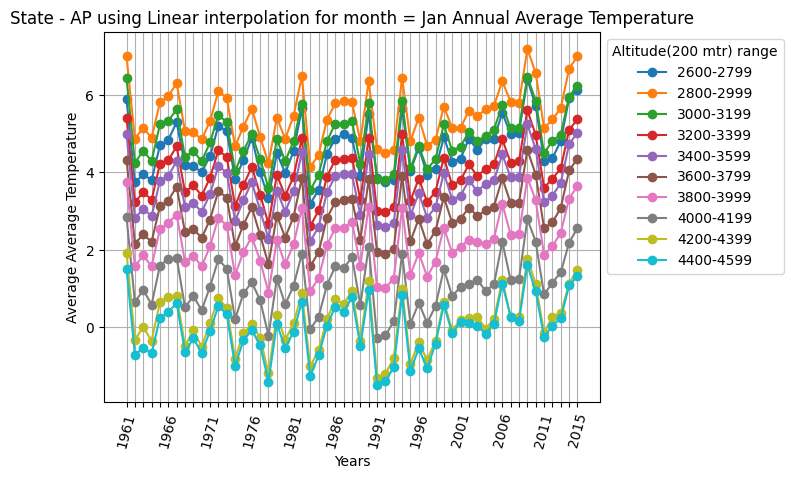

---Plotted graph for AP-Linear-Jan----
--------------------Plotting the graph completed-----------------


In [4]:
import logging
log_filename = './TemperatureAnalysis/LOGFILES/7_PlottingTheGraph.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Create a StreamHandler and add it to the logger
stream_handler = logging.StreamHandler()
logging.getLogger().addHandler(stream_handler)
logging.info('--------------------Plotting the graph started-----------------')
yearstoshow = [1,6]
logging.info(f'---yearstoshow = {yearstoshow}-----')
doPlottingTemp(yearstoshow,logging)
logging.info('--------------------Plotting the graph completed-----------------')

# 8.Trend Analysis

## Mann Kendall’s 
Doing for all at once

In [19]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import pandas as pd
import matplotlib.pyplot as plt
def DoMannkendallTest(df, State, interpolation, month):
    # Create a list to store the results
    results = []

    for altitude_range in df.index:
        # Filter the data frame to the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        values = values[1:]
        
        # Perform the Mann-Kendall test
        mann_kendall_test_result = mk.original_test(values)
        
        # Extract relevant test statistics
        tau = mann_kendall_test_result.Tau
        trend = mann_kendall_test_result.trend
        p_value = mann_kendall_test_result.p
        slope = mann_kendall_test_result.slope

        tau = round(float(tau), 5)
        p_value = round(float(p_value), 5)
        slope = round(float(slope), 5)
        
        # Append the results to the list
        results.append([State,month,first_value,interpolation, trend, p_value])

    # results_df = pd.DataFrame(results, columns=['Altitude Range', 'Interpolation', 'Trend', 'Tau', 'p-value', 'Slope'])
    results_df = pd.DataFrame(results, columns=['State','Month', 'Altitude Range', 'Interpolation', 'Trend', 'p-value'])
    return results_df


def TrendAnalysisMannKendall(logging):
    typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
    State = ['AP', 'HP', 'SK', 'UK', 'J&K']
    InterpolateRangeWise = './TemperatureAnalysis//InterpolateRangeWise'
    desired_month_order = ['Jan', 'Feb', 'Mar', 'Apr',
                           'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for state in State:
        logging.info(f'Doing mk test for {state}')
        result = pd.DataFrame()
        name = state
        for interpolation in typeofInterpolation:
            logging.info(f'---State = {name} --, interpoation = {interpolation}-----')
            interpolationfile = interpolation + '200'
            __path__ = os.path.join(InterpolateRangeWise, state)
            __path__ = os.path.join(__path__, interpolationfile)
            # visitng monthwise files
            for month in desired_month_order:
                logging.info(
                    f'---State = {name} , {month}--, interpoation = {interpolation}-----')
                monthfilename = [file for file in os.listdir(
                    __path__) if month in file][0]
                # Read monthfile
                logging.info(f'--------mk Tesst for state {name}-- {month}-- {interpolation}-------------------')
                df = pd.read_excel(os.path.join(__path__, monthfilename))
                res = DoMannkendallTest(df, name, interpolation, month)
                result = pd.concat([result, res], ignore_index=True)
                result = pd.concat([result, pd.DataFrame(
                    {'Year': [np.nan], 'Trend': [np.nan]}).set_index('Year')], ignore_index=True)
                # Add an empty row to separate results
                # result = pd.concat([result, pd.DataFrame(columns=result.columns)], ignore_index=True)
        # ipdb.set_trace()
        empty_row = [np.nan] * 6
        result.append(empty_row)
        result.append(empty_row)
        SaveTestResults(result, name)
        logging.info(f'--------mk Tesst for state {name}-- completed-------------------')
            
    
def SaveTestResults(result, name):
    path = './TemperatureAnalysis/MannKendallTestResults'
    if not os.path.exists(path):
        os.makedirs(path)
    folder = os.path.join(path, name)
    if not os.path.exists(folder):
        os.makedirs(folder)
    file = os.path.join(folder, name + 'MkTest.xlsx')
    # result.to_excel(file, index=False)
    result.to_excel(file, index=False, engine='openpyxl', sheet_name=f'TempMannKendallTest-{name}')


In [ ]:
import logging
log_filename = './TemperatureAnalysis/LOGFILES/8_MenkandallTest.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
TrendAnalysisMannKendall(logging)


# Sen Slope's Test

In [17]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def slopeTest(df,state_name,interpolation, month):
    results = []
    for altitude_range in df.index:
        # Extract the precipitation values for the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        precipitation = values[1:]  # Extract precipitation data
        
        # Convert precipitation data and years to NumPy arrays
        precipitation = np.array(precipitation, dtype=float)
        years = np.array(df.columns[1:], dtype=int)
        # ipdb.set_trace()
        # Perform linear regression to calculate the slope
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, precipitation)
        # Find the p-value
        # Calculate t-statistic
        # t = slope / (std_err / np.sqrt(np.sum((years - np.mean(years))**2)))
        # p_value2 = 2 * (1 - stats.t.cdf(np.abs(t), len(years) - 2))
        if p_value < 0.05:
            result = "Reject"
        else:
            result = "Fail to reject"
        results.append([state_name, month, first_value,interpolation,  p_value, result])

    # Print the extracted state name
    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results, columns=['State','Month', 'Altitude Range', 'Interpolation', 'p-value','Result'])
    return results_df

   
def TrendAnalysisSlopeTest(logging):
    typeofInterpolation = ['Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW']
    State = ['AP', 'HP', 'SK', 'UK','J&K']
    InterpolateRangeWise = './TemperatureAnalysis/InterpolateRangeWise'
    desired_month_order = ['Jan', 'Feb', 'Mar', 'Apr',
                           'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for state in State:
        logging.info(f'Doing mk test for {state}')
        result = pd.DataFrame()
        name = state
        for interpolation in typeofInterpolation:
            logging.info(f'---State = {name} --, interpoation = {interpolation}-----')
            interpolationfile = interpolation + '200'
            __path__ = os.path.join(InterpolateRangeWise, state)
            __path__ = os.path.join(__path__, interpolationfile)
            # visitng monthwise files
            for month in desired_month_order:
                logging.info(
                    f'---State = {name} , {month}--, interpoation = {interpolation}-----')
                monthfilename = [file for file in os.listdir(__path__) if month in file][0]
                # Read monthfile
                logging.info(f'--------Sen SlopeTesst for state {name}-- {month}-- {interpolation}-------------------')
                df = pd.read_excel(os.path.join(__path__, monthfilename))
   
                res = slopeTest(df, name,interpolation,month)
                result = pd.concat([result, res], ignore_index=True)
                result = pd.concat([result, pd.DataFrame({'Result': [np.nan]})], ignore_index=True)
                 # Add an empty row to separate results
                # result = pd.concat([result, pd.DataFrame(columns=result.columns)], ignore_index=True)
        empty_row = [np.nan] * 6
        result.append(empty_row)
        result.append(empty_row)
        SaveTestResults(result, name)
        logging.info(f'--------mk Tesst for state {name}-- completed-------------------')
        logging.info('')
            
    
def SaveTestResults(result, name):
    path = './TemperatureAnalysis/SlopeSenTestResults'
    if not os.path.exists(path):
        os.makedirs(path)
    folder = os.path.join(path, name)
    if not os.path.exists(folder):
        os.makedirs(folder)
    file = os.path.join(folder, name + 'SenSlopeTest.xlsx')
    # result.to_excel(file, index=False)
    result.to_excel(file, index=False, engine='openpyxl', sheet_name=f'TempSenSlopeTest-{name}')

In [ ]:
import logging
log_filename = './TemperatureAnalysis/LOGFILES/8_SenSlopeTest.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
TrendAnalysisSlopeTest(logging)

# 9. Saving all States, for all Months annual mean

In [13]:
def getMeanAnnually(state,interpolation,month,monthfile,interpolationFolder, SavingFolder,logger):
    #check saving folderexists
    if not os.path.exists(SavingFolder):
        logger.info(f'----folder {SavingFolder} not exists----')
        logger.info(f'----creating folder {SavingFolder}----')
        os.makedirs(SavingFolder)
    logger.info(f'for {state},--- {month},----- {interpolation},saving file')
    __path__ = interpolationFolder
    file = monthfile
    df = pd.read_excel(__path__ + f'/{file}')
    newName = file.split('.')[0] + '_MeanAnnually.xlsx'
    
    # Drop Latitude and Longitude columns
    df = df.drop(columns=['Latitude', 'Longitude'])
    max_altitude = df["Altitude"].max()
    min_altitude = df["Altitude"].min()
    # Create a range string
    altitude_range = f"{month} : {min_altitude}-{max_altitude}"   
    #Now find Mean Annually
    # Create a range string

    # Calculate the mean temperature for each year
    mean_temperatures = df.drop(columns=['Altitude']).mean()
    # Rename the columns to include "mean" and the year
    mean_temperatures.index = [year for year in mean_temperatures.index]
    result_df = mean_temperatures.to_frame().T # Transpose the DataFrame
    # Print the Altitude range and mean temperatures
    altitude_range_df = pd.DataFrame({'Altitude range': [altitude_range]})
    # Concatenate the altitude_range_df with the existing DataFrame
    result_df = pd.concat([altitude_range_df, result_df], axis=1)
    result_df.to_excel(SavingFolder + '/' + newName, index=False)

In [19]:
import logging
def createFolder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def getMonth(monthfile):
    #AP_Apr.xlsx
    month = monthfile.split('.')[0].split('_')[1]
    return month

log_filename = './TemperatureAnalysis/LOGFILES/9SavingAllMonthsMeanAltitude.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
__path__ = './TemperatureAnalysis/InterpolationExcelFile'
interpolationFolder = './TemperatureAnalysis/InterpolationExcelFile'
MeanSavingDir = './TemperatureAnalysis/MonthlyMeanInWholeState'
createFolder(MeanSavingDir) 
#  './TemperatureAnalysis/TemperatureTesting/MonthlyMeanInWholeState'

## Now find Mean Annually
for state in os.listdir(interpolationFolder):
    if state == 'AP':
        continue
    if state == 'HP':
        continue
    if state == 'SK':
        continue
    if state == 'UK':
        continue
    #'./TemperatureAnalysis/TemperatureTesting/InterpolationExcelFile/AP
    MeanSaving_StateDir = MeanSavingDir + '/' + state
    createFolder(MeanSaving_StateDir)
    StateinterpolationFolder  = interpolationFolder + '/' + state
    temp = ['Cubic', 'IDW','Linear','Nearest']
    for interpolation in os.listdir(StateinterpolationFolder):
        if interpolation  in temp:
            continue
        InterpolationStateInterpolationFolder = StateinterpolationFolder + '/' + interpolation
        MeanSaving_State_InterpolationDir = MeanSaving_StateDir + '/' + interpolation
        createFolder(MeanSaving_State_InterpolationDir)
        for monthfile in os.listdir(InterpolationStateInterpolationFolder):
            if not monthfile.endswith('.xlsx'):
                continue
            lst = ['J&K_Apr_MeanAnnually.xlsx','J&K_Aug_MeanAnnually.xlsx','J&K_Dec_MeanAnnually.xlsx',
                   'J&K_Feb_MeanAnnually.xlsx','J&K_Jan_MeanAnnually.xlsx','J&K_Jul_MeanAnnually.xlsx',
                   'J&K_Jun_MeanAnnually.xlsx','J&K_Mar_MeanAnnually.xlsx',]
            if monthfile in lst:
                continue
            month = getMonth(monthfile)
            print(f'----{state}--{month}--{interpolation}--started---')
            getMeanAnnually(state,interpolation,month,monthfile, InterpolationStateInterpolationFolder,MeanSaving_State_InterpolationDir,logging)
            logging.info(f'----{state}--{month}--{interpolation}--completed---')

----J&K--Apr--MIDW--started---
----J&K--Aug--MIDW--started---
----J&K--Dec--MIDW--started---
----J&K--Feb--MIDW--started---
----J&K--Jan--MIDW--started---
----J&K--Jul--MIDW--started---
----J&K--Jun--MIDW--started---
----J&K--Mar--MIDW--started---
----J&K--May--MIDW--started---
----J&K--Nov--MIDW--started---
----J&K--Oct--MIDW--started---
----J&K--Sep--MIDW--started---


# 10.Printing and plotting results as given by user

Arguments to provide
1. State -- which state
2. Months - which month or write if needed for annual
3. Type of interpolation - Linear, Cubic, Nearest, IDW, MIDW


-> Diplay
1. State Altitude Range wise Temperature variaton
2. Mankendall test results and Slope Test resluts with table

-----------------doing here------------------

In [1]:
import xarray as xr
import geopandas as gpd
import regionmask
import numpy as np
import pandas as pd
from openpyxl import Workbook
import os
import io
import ipdb
from scipy.interpolate import griddata
from sklearn.neighbors import KNeighborsRegressor
import time
import matplotlib.pyplot as plt
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output, display_html, HTML
import logging
from ipywidgets import Dropdown
# Ignore FutureWarnings
from tabulate import tabulate
import pymannkendall as mk
import scipy.stats as stats
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore", category=FutureWarning)
import textwrap

In [4]:
def PrintSenSlopeTest(df,state_name, month, interpolation, YearRange, Season):
    if Season == 'Annually':
        month = ['Annual']
    results = []
    YearRange = [str(year) for year in YearRange]
    yearcounted = int(YearRange[-1]) - int(YearRange[0]) + 1
    year_range = f'{YearRange[0]} - {YearRange[-1]} #({yearcounted} years timeseries)'
    df = df.loc[:, YearRange]
    for altitude_range in df.index:
        # Extract the precipitation values for the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        precipitation = values[1:]  # Extract precipitation data
        
        # Convert precipitation data and years to NumPy arrays
        precipitation = np.array(precipitation, dtype=float)
        years = np.array(df.columns[1:], dtype=int)
        # Perform linear regression to calculate the slope
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, precipitation)
        # Find the p-value
        # Calculate t-statistic
        # t = slope / (std_err / np.sqrt(np.sum((years - np.mean(years))**2)))
        # p_value2 = 2 * (1 - stats.t.cdf(np.abs(t), len(years) - 2))
        r_square = r_value**2
        if p_value < 0.05:
            result = "Reject"
        else:
            result = "Fail to reject"
        results.append([state_name, month, altitude_range,year_range, interpolation,  p_value, slope, result])

    # Print the extracted state name
    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results, columns=['State','Month', 'Altitude Range','year_range', 'Interpolation', 'p-value', 'slope', 'Result'])
    print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))
    outcomes = {
        "Reject the null hypothesis": "This means that the data provides sufficient evidence to conclude that the null hypothesis is false.",
        "Fail to reject the null hypothesis": "This means that the data does not provide sufficient evidence to conclude that the null hypothesis is false.",
    }

    # Print formatted outcomes
    for outcome, description in outcomes.items():
        formatted_text = textwrap.fill(description, width=60)  # Adjust the width as needed
        print(f"{outcome}:\n{formatted_text}\n")


def PrintMankendallTest(df, State, month, interpolation, YearRange, Season):
    # Create a list to store the results
    if Season == 'Annually':
        month = ['Annual']
    results = []
    #Change YearRange to string as df.columns is string
    #modify the df now
    YearRange = [str(year) for year in YearRange]
    yearcounted = int(YearRange[-1]) - int(YearRange[0]) + 1
    year_range = f'{YearRange[0]} - {YearRange[-1]} #({yearcounted} years timeseries)'
    df = df.loc[:, YearRange]
    for altitude_range in df.index:
        # Filter the data frame to the current altitude range
        values = df.loc[altitude_range].values
        first_value = values[0]  # Capture the first value
        values = values[1:]
        
        # Perform the Mann-Kendall test
        mann_kendall_test_result = mk.original_test(values)
        
        # Extract relevant test statistics
        tau = mann_kendall_test_result.Tau
        trend = mann_kendall_test_result.trend
        p_value = mann_kendall_test_result.p
        slope = mann_kendall_test_result.slope
        z_test_statics = mann_kendall_test_result.z
        tau = round(float(tau), 5)
        p_value = round(float(p_value), 5)
        slope = round(float(slope), 5)
        
        # Append the results to the list
        results.append([State,month,altitude_range,year_range, interpolation, p_value,z_test_statics, trend])

    # results_df = pd.DataFrame(results, columns=['Altitude Range', 'Interpolation', 'Trend', 'Tau', 'p-value', 'Slope'])
    results_df = pd.DataFrame(results, columns=['State','Month', 'Altitude Range','year_range', 'Interpolation', 'p-value','z_test_statics', 'Trend'])
    # Print the DataFrame beautifully
    print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))
    outcomes = {
                'p-value < 0.05, z_test_statics > 0' :	'Statistically significant increasing trend',
                'p-value < 0.05, z_test_statics < 0' :	'Statistically significant decreasing trend',
                'p-value > 0.05' :	'Fail to reject the null hypothesis of no trend',
                 'Note ': 'It is a non-parametric measure, so it does not make any assumptions about the distribution of the data.'
                }
    for outcome, description in outcomes.items():
        formatted_text = textwrap.fill(description, width=60)  # Adjust the width as needed
        print(f"{outcome}:\n{formatted_text}\n")

def ShowGraphTemp(df,month,State,interpolation,x_ticks, YearRange,Season):
    # Set the 'Altitude Range' column as the index
    print(Season)
    if Season == 'Annually':
        month = ['Annual']
    if 'Altitude Range' in df.columns:
        df.set_index('Altitude Range', inplace=True)
    elif 'Altitude range' in df.columns:
        df.set_index('Altitude range', inplace=True)
    # Set the figure size before creating the plot
    YearRange = [str(year) for year in YearRange]
    yearcounted = int(YearRange[-1]) - int(YearRange[0]) + 1
    year_range = f'{YearRange[0]} - {YearRange[-1]} #({yearcounted} years timeseries)'
    plt.figure(figsize=(12, 20))  
    # Create a line plot
    ax = df.T.plot(kind='line', marker='o')
    extrayear = '2015'
    # Customize the plot (labels, title, etc.)
    plt.xlabel('Years of Time Series')
    plt.ylabel('Average Average Temperature (°C)')
    if Season == 'Seasonally':
        plt.title(f'State={State}, interpolation={interpolation}, Season = {Season}, Months = {month} on Mean Average Temperature\n{year_range}')
    
    elif Season == 'Annually':
        plt.title(f'State={State}, interpolation={interpolation}, Annually on Mean Average Temperature\n{year_range}')
    else:
        plt.title(f'State - {State} using {interpolation} interpolation for month = {month} ,{Season} mean Average Temperature\n{year_range}')

    # Customize the x-axis tick labels to emphasize every 10 years
    x_values = list(df.columns)
    # x_labels = [year if int(year) % 10  in yeartoshow else year for year in x_values]
    x_labels = [year if int(year[-1]) % 10 in x_ticks or year == extrayear else '' for year in x_values]
    plt.xticks(range(len(x_values)), x_labels, rotation=75)
    # Move the legend outside the plot to the upp   er right
    plt.legend(title='Altitude(200 mtr) range', loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

In [2]:
def getresults(results,MinMaxRange):
        year_wise_data = results.iloc[0:,0:]
        result_mean = year_wise_data.mean().to_frame().T
        result_mean.insert(0, 'Altitude Range', MinMaxRange)
        result_mean = result_mean.set_index('Altitude Range')
        return result_mean

def getmaxminAltitudeVAlues(df):
    minAltitude = df.iloc[1, 0].split('-')[0]
    maxAltitude = df.iloc[-1, 0].split('-')[1]
    MinMaxRange = f'{minAltitude}-{maxAltitude}'
    AltitudeRange = df['Altitude Range'].values
    return MinMaxRange, AltitudeRange


def DoComputations(state, Analysis_type, Months, interpolation, x_ticks, YearsRange, Season):
    interpolatoinRangeWisePath = './TemperatureAnalysis/InterpolateRangeWise'
    name = state
    if Analysis_type == 'Monthly':
        _path_ = interpolatoinRangeWisePath + f'/{state}/{interpolation}200'
        monthname = None
        for month in Months:
            monthname = month
            # ShowingBy altitude Range
            print('Showing by various altitude range')
            logging.info(
                    f'---State = {state} , {month}--, interpoation = {interpolation}-----')
            monthfilename = [file for file in os.listdir(_path_) if month in file][0]
            df = pd.read_excel(os.path.join(_path_, monthfilename))
            ShowGraphTemp(df, month, state, interpolation, x_ticks, YearsRange, Season)
            logging.info(f'---Plotted graph for {name}-{interpolation}-{month}----')

            print('Showing Mankendall test for month', month)
            PrintMankendallTest(df, state, month, interpolation,YearsRange, Season)
            logging.info(f'---Showing Sen Slope test for {name}-{interpolation}-{month}----')

            print(f'---Showing Sen Slope test for {name}-{interpolation}-{month}----')
            PrintSenSlopeTest(df, state, month, interpolation,YearsRange, Season)  
            

            logging.info('')
            print('Shoing Complete state graph')
            #Now get mean of all rows leaving first column
            #now create a new dataframe give name = {state}-Timberline to first column
            # and mean of rows from 2nd colmn to last
        
        #Now go for complete state graph for that month
        _path_  = f'TemperatureAnalysis/MonthlyMeanInWholeState/{state}/{interpolation}'
        monthMeanFilename = [file for file in os.listdir(_path_) if monthname in file][0]
        df = pd.read_excel(os.path.join(_path_, monthMeanFilename))
        ShowGraphTemp(df, monthname,state, interpolation, x_ticks, YearsRange, Season)
        logging.info(f'---Plotted graph for {name}-{interpolation}-{monthname} mean----')


        print('Temperature Analysis:Showing Mankendall test for month', monthname)
        PrintMankendallTest(df, state, month, interpolation,YearsRange,Season)

        print(f'-Temperature Analysis : Showing Sen Slope test for {name}-{interpolation}-{monthname} mean----')
        logging.info(f'---Temperature Analysis : Showing Sen Slope test for {name}-{interpolation}-{monthname} mean----')
        PrintSenSlopeTest(df, state, monthname, interpolation,YearsRange, Season)




    elif Analysis_type == 'Annually' or Analysis_type == 'Seasonally':
        _path_ = interpolatoinRangeWisePath + f'/{state}/{interpolation}200'
        #with range and without range
        YearsRange = [str(year) for year in YearsRange]
        #with altitude range
        results = None
        altitude_range = None
        desired_months_files = []#Getting desired files
        for month in Months:
            for monthfile in os.listdir(_path_):
                if month in monthfile:
                    desired_months_files.append(monthfile)
                    break
        # It will be used when we combine a whole month file
        tempfile = desired_months_files[0]
        tempdf = pd.read_excel(os.path.join(_path_, tempfile))
        MinMaxRange, altitude_range = getmaxminAltitudeVAlues(tempdf)

        for monthfile in desired_months_files:
            file_path_ = os.path.join(_path_, monthfile)
            df = pd.read_excel(file_path_)
            # Store altitude_range if it's not already stored
            
            df = df.loc[:, YearsRange]
            #if results is empty then copy df to results
            # Extract data (excluding first row and first column)
            data = df.iloc[0:, 0:]
            # Initialize results DataFrame if it's None
            if results is None:
                results = data
            else:
                # Add the data to the results DataFrame
                results = results.add(data, fill_value=0)
        # Calculate the mean by dividing by the number of files
        results_mean = results / len(desired_months_files)
        #now get year of results
        results_mean.insert(0, 'Altitude Range', altitude_range)
        results_mean = results_mean.set_index('Altitude Range')

        df = results_mean
        # Set the altitude range and years as the first row and first column
        ShowGraphTemp(df, Months, state, interpolation, x_ticks, YearsRange, Season)
        logging.info(f'---Plotted graph for {name}-{interpolation}-{Months}----')

        print('Temperature analysis Showing Mankendall test for month', Months)
        PrintMankendallTest(df, state, Months, interpolation,YearsRange, Season)
        logging.info(f'---Showing Sen Slope test for {name}-{interpolation}-{Months}----')

        print(f'Temperature analysis Showing Sen Slope test for {name}-{interpolation}-{Months}')
        PrintSenSlopeTest(df, state, Months, interpolation,YearsRange, Season) 
        

        #Now show complete analysis for all altitude range
        modified_df = getresults(df,MinMaxRange)
        ShowGraphTemp(modified_df, Months, state, interpolation, x_ticks, YearsRange, Season)
        logging.info(f'---Plotted graph for {name}-{interpolation}-Annual----')

        print('Temperature analysis Showing Mankendall test for month', Months)
        PrintMankendallTest(modified_df, state, Months, interpolation,YearsRange, Season)
        logging.info(f'---Showing Sen Slope test for {name}-{interpolation}-Annual----')

        print(f'Temperature analysis Showing Sen Slope test for {name}-{interpolation}-Annually')
        PrintSenSlopeTest(modified_df, state, Months, interpolation,YearsRange, Season) 



In [ ]:

def flatten_list(input_list):
    result = []
    for item in input_list:
        if isinstance(item, tuple):
            result.extend(item)
        else:
            result.append(item)
    return result

log_filename = './TemperatureAnalysis/LOGFILES/9_PlottingTheGraph.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Output widget for displaying results
output = widgets.Output()
selected_state = None
selected_analysis_type = None
selected_months = None
selected_interpolation = None
selected_years_to_show = None
selected_years_to_extract = None
selected_season = None
Months = [] 
Analysis_type = None
Season = 'Monthly'
def on_submit_button_click(b, Months=Months):
    with output:
        clear_output()  # Clear previous output

        global selected_state
        global selected_analysis_type
        global selected_months
        global selected_interpolation
        global selected_years_to_show
        global selected_years_to_extract
        global Season
        global Analysis_type
        selected_state = state_dropdown.value
        selected_analysis_type = analysis_dropdown.value
        selected_months = list(Months)
        selected_interpolation = interpolation_dropdown.value
        selected_years_to_show = yearstoshow_Multioption.value
        selected_years_to_extract = yearstoextract_slider.value
        
        # Log the selected values
        logging.info(f'States: {selected_state}')
        logging.info(f'Season: {Season}')
        logging.info(f'Analysis_type: {selected_analysis_type}')
        logging.info(f'Months: {selected_months}')
        logging.info(f'Interpolation: {selected_interpolation}')
        logging.info(f'Years to Show: {selected_years_to_show}')
        logging.info(f'Years to Extract: {selected_years_to_extract}')
        logging.info('') 

        print('Selected values logged.')
        print(f'States: {selected_state}')
        print(f'Season: {Season}')
        print(f'Analysis_type: {selected_analysis_type}')
        print(f'Months: {selected_months}')
        print(f'Interpolation: {selected_interpolation}')
        print(f'Years to Show: {selected_years_to_show}')
        print(f'Years to Extract: {selected_years_to_extract}')
        #  with output:
        #     clear_output()
        state, Analysis_type, Months, Interpolation, ModVal = selected_state, selected_analysis_type, flatten_list(selected_months) ,selected_interpolation, flatten_list(selected_years_to_show)
        Years = list(range(selected_years_to_extract[0], selected_years_to_extract[1]+1))

        DoComputations(state, Analysis_type, Months, Interpolation, ModVal, Years, Season)


def clear_and_display(widget):
    global Season
    with output:
        clear_output()
        display(widget)

def on_month_dropdown_change(month_change,Months=Months):
    Months.clear()
    month_dropdown = month_change.new
    Months = Months.append(month_dropdown)
    print(f'Selected Months: {month_dropdown}')


def on_Season_change(season_change):
    global Season
    season_change = season_change.new
    Season = season_change
    print(f'Selected Season: {season_change}')

def create_analysis_widgets(selected_analysis):
    global Season
    with output:
        clear_output()  # Clear previous output
        Analysis_type = selected_analysis
        if selected_analysis == 'Monthly':
            #create a dropdown for month
            Season = selected_analysis
            month_dropdown = widgets.Dropdown(
                options=['Choose Month','Jan', 'Feb', 'Mar', 'Apr', 'May', 
                        'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                value='Choose Month',
                description='Monthwise:'
            )
            # Add an observer to capture the selected values
            month_dropdown.observe(on_month_dropdown_change, names='value')
            display(month_dropdown)


        elif selected_analysis == 'Seasonally':
            #Create a dropdown for season
            season_dropdown = widgets.Dropdown(
                options=['Choose Season','Winter', 'Summer', 'Monsoon', 'PostMonsoon'],
                value='Choose Season',
                description='Select Seasons:'
            )
            display(season_dropdown)

            def on_season_dropdown_change(season_change):
                selected_season = season_change.new
                global Season
                Season = season_change.new
                print(f'Selected Season: {selected_season}')
                with output:
                    clear_output()
                    if selected_season == 'Winter':
                        month_dropdown = widgets.SelectMultiple(
                            options=['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar'],
                            value=[],  # Set default selected months for Winter here
                            description='Select Months:'
                        )
                        month_dropdown.observe(on_month_dropdown_change, names='value')
                        display(month_dropdown)

                    elif selected_season == 'Summer':
                        month_dropdown = widgets.SelectMultiple(
                            options=['Mar', 'Apr', 'May','Jun', 'Jul', 'Aug'],
                            value=[],  # Set default selected months for Winter here
                            description='Select Months:'
                        )
                        month_dropdown.observe(on_month_dropdown_change, names='value')
                        display(month_dropdown)
                    elif selected_season == 'Monsoon':
                        month_dropdown = widgets.SelectMultiple(
                            options=['Jun', 'Jul', 'Aug', 'Sep'],
                            value=[],  # Set default selected months for Winter here
                            description='Select Months:'
                        )
                        month_dropdown.observe(on_month_dropdown_change, names='value')
                        display(month_dropdown)
                    elif selected_season == 'PostMonsoon':
                        month_dropdown = widgets.SelectMultiple(
                            options=['Sep', 'Oct', 'Nov', 'Dec'],
                            value=[],  # Set default selected months for Winter here
                            description='Select Months:'
                        )
                        month_dropdown.observe(on_month_dropdown_change, names='value')
                        display(month_dropdown)
            season_dropdown.observe(on_season_dropdown_change, names='value')





        elif selected_analysis == 'Annually':
            Season = selected_analysis
            select_all_button = widgets.Button(description='Select All Months')

            def select_all_months(b):
                month_dropdown.value = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                    'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
                
            select_all_button.on_click(select_all_months)
            month_dropdown = widgets.SelectMultiple(
            options=['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                    'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            value=[],
            description='Monthwise:'
            )

            # Display both the 'Select All' button and the month dropdown
            display(select_all_button)
            month_dropdown.observe(on_month_dropdown_change, names='value')
            display(month_dropdown)
            return month_dropdown


# Create dropdown widget for states
state_dropdown = widgets.Dropdown(
    options=['Select State','UK', 'J&K', 'AP', 'HP', 'SK'],
    value='Select State',
    description='States:'
)
#
interpolation_dropdown = widgets.Dropdown(
    options=['Select Interpolation','Linear', 'Cubic', 'Nearest', 'IDW', 'MIDW'],
    value='Select Interpolation',
    description='Interpolation:'
)

# Create dropdown widget for type of analysis
analysis_dropdown = widgets.Dropdown(
    options=['SelectAnalysis','Monthly', 'Annually', 'Seasonally'],
    value='SelectAnalysis',
    description='Type of Analysis:'
)


# Create a multi-option widget for 'yearstoshow_Multioption'
yearstoshow_Multioption = widgets.SelectMultiple(
    options=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    value=[1,5],  # You can set the default selected options here
    description='Years to Show:'
)


yearstoextract_slider = widgets.IntRangeSlider(
    value=[1961, 2015],  # Set initial range as needed
    min=1961,             # Set minimum and maximum year values as needed
    max=2015,
    step=1,
    description='Years to Extract:'
)

# Function to handle changes in the type of analysis dropdown
# month_dropdown.observe(on_month_dropdown_change, names='value')
def on_analysis_dropdown_change(change):
    create_analysis_widgets(change.new)

# Attach the change event handler to the analysis dropdown
analysis_dropdown.observe(on_analysis_dropdown_change, names='value')

# Attach the click event handler to the button
submit_button = widgets.Button(description='Submit')
submit_button.on_click(on_submit_button_click)

input_widgets = widgets.VBox([
    state_dropdown, 
    # month_dropdown, 
    interpolation_dropdown,     
    yearstoshow_Multioption, 
    yearstoextract_slider, 
    analysis_dropdown,  # Include the type of analysis dropdown
    submit_button
])
 
# Display the input widgets

# Display the output area
display(input_widgets)
display(output)

def on_clear_button_click(b):
    """Resets the form and clears the output."""

    # Clear the input values
    state_dropdown.value = 'Select State'
    interpolation_dropdown.value = 'Select Interpolation'
    yearstoshow_Multioption.value = [1, 5]
    yearstoextract_slider.value = [1961, 2015]
    analysis_dropdown.value = 'SelectAnalysis'

    # Clear the output
    with output:
        clear_output()
# Add a clear button
clear_button = widgets.Button(description='Clear')

# Attach the click event handler to the clear button
clear_button.on_click(on_clear_button_click)

# Display the clear button
display(clear_button)


Output()

Button(description='Clear', style=ButtonStyle())

Selected Months: Sep
Selected Months: Jun


Selected Months: ('Jan',)
Selected Months: ('Jan', 'Feb')
Selected Months: ('Jan', 'Feb', 'Mar')


Selected Months: Jul


Selected Months: ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
